# The MattingMen Proudly Present: Image Matting, Neural and Classical

### Download the Dataset

In [2]:
import gdown
from zipfile import ZipFile
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# def download_and_extract(zip_url, extract_to='./archive/', zip_path='temp.zip'):
#     file_id = zip_url.split('/')[-2]
#     drive_url = f"https://drive.google.com/uc?id={file_id}"
#     gdown.download(drive_url, zip_path, quiet=False)
    
#     with ZipFile(zip_path, 'r') as zip_ref: 
#         zip_ref.extractall(extract_to)
#     os.remove(zip_path)

# google_drive_link = "https://drive.google.com/file/d/1ZWjgJ762I40bYn9DC9IDAsDbvwJ8Dqm5/view?usp=drive_link"
# download_and_extract(google_drive_link)

#### Double Check That It's Working

In [3]:
def create_image_dataframe(root_dir):
    data = []
    
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if 'clip_' in subdir:
                image_type = 'clip'
            elif 'matting_' in subdir:
                image_type = 'matting'
            else:
                continue
                
            filename_without_extension = os.path.splitext(file)[0]
            full_path = os.path.join(subdir, file)
            
            data.append([filename_without_extension, full_path, image_type])
    
    df = pd.DataFrame(data, columns=['image_name', 'path', 'type'])
    return df

root_directory = './archive/'
image_df = create_image_dataframe(root_directory)

print(image_df.head())


            image_name                                               path  \
0  1803232244-00000010  ./archive/matting/1803232244/matting_00000000/...   
1  1803232244-00000428  ./archive/matting/1803232244/matting_00000000/...   
2  1803232244-00000372  ./archive/matting/1803232244/matting_00000000/...   
3  1803232244-00000399  ./archive/matting/1803232244/matting_00000000/...   
4  1803232244-00000158  ./archive/matting/1803232244/matting_00000000/...   

      type  
0  matting  
1  matting  
2  matting  
3  matting  
4  matting  


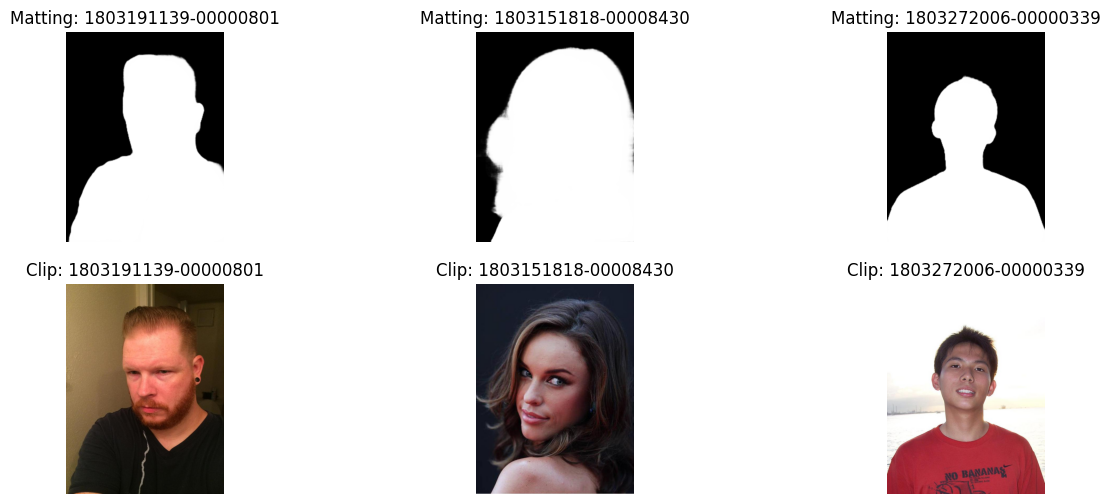

In [4]:
def display_image_pairs(df, num_images=3):
    matting_images = df[df['type'] == 'matting']
    clip_images = df[df['type'] == 'clip']
    
    selected_matting = matting_images.sample(n=num_images)
    
    _, axs = plt.subplots(2, num_images, figsize=(15, 6))
    
    for i, (_, row) in enumerate(selected_matting.iterrows()):
        matting_img = cv2.imread(row['path'], cv2.IMREAD_UNCHANGED)
        clip_row = clip_images[clip_images['image_name'] == row['image_name']].iloc[0]

        clip_img = cv2.imread(str(clip_row['path']))
        clip_img = cv2.cvtColor(clip_img, cv2.COLOR_BGR2RGB)
        
        axs[0, i].imshow(matting_img[:,:,3], cmap='gray')
        axs[0, i].set_title(f"Matting: {row['image_name']}")
        axs[0, i].axis('off')
        
        axs[1, i].imshow(clip_img)
        axs[1, i].set_title(f"Clip: {row['image_name']}")
        axs[1, i].axis('off')
    
    plt.show()

# Assume `image_df` is the DataFrame created previously
display_image_pairs(image_df, num_images=3)

def load_img(df, idx, normalize_to_float=False):
    matting_row = df[df['type'] == 'matting'].iloc[idx]
    clip_row = df[df['type'] == 'clip'].iloc[idx]
    matting_img = cv2.imread(matting_row['path'], cv2.IMREAD_UNCHANGED)[:,:,3]
    clip_img = cv2.imread(str(clip_row['path']))
    clip_img = cv2.cvtColor(clip_img, cv2.COLOR_BGR2RGB)

    if(normalize_to_float):
        clip_img = clip_img / 255.0
        matting_img = matting_img / 255.0
    return matting_img.astype(np.float32), clip_img.astype(np.float32)


# Practice Eroding Images

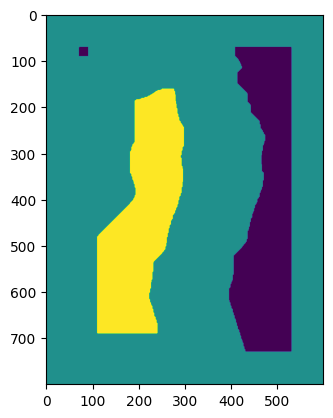

In [53]:
def get_squiggles(image, threshold=4, area=0.1):
    kernel = np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ], dtype=np.uint8)
    
    #set up the foreground and background squiggles
    target_alpha = image.copy()
    background_alpha = 255-image.copy()
    
    #get mask ratios set up
    mask1_initial_total = np.sum(image)
    mask2_initial_total = np.sum(255-image)
    mask1_area = mask1_initial_total
    mask2_area = mask2_initial_total

    #erode both until they're 10% of the original area
    while(mask1_area / mask1_initial_total > area):
        neighbor_count = cv2.filter2D((target_alpha > 0).astype(np.uint8), -1, kernel, borderType=cv2.BORDER_CONSTANT)
        target_alpha[(neighbor_count < threshold) & (target_alpha > 0)] = 0
        mask1_area = np.sum(target_alpha)
        
        

    while(mask2_area / mask2_initial_total > area):
        neighbor_count = cv2.filter2D((background_alpha >0).astype(np.uint8), -1, kernel, borderType=cv2.BORDER_CONSTANT)
        background_alpha[(neighbor_count < threshold) & (background_alpha > 0)] = 0
        mask2_area = np.sum(background_alpha)

    target_alpha=cv2.blur(target_alpha, (20,20)) > 1
    background_alpha=cv2.blur(background_alpha,(20,20)) > 1
    #throw the squiggles together on a canvas of grey as the closed form implementation seems to expect
    canvas = np.ones_like(image)
    canvas = canvas/2 + target_alpha/2 - background_alpha/2

    return canvas

matting, color = load_img(image_df, 10)
result_image = get_squiggles(matting, threshold=2, area=.2)

plt.imshow(result_image)

### Confirming this works with the matting implementation we found:

In [ ]:
from __future__ import division
import cv2
import numpy as np
from numpy.lib.stride_tricks import as_strided
import scipy.sparse
import scipy.sparse.linalg
import pypardiso
import pandas as pd

## U-Net Time!
Below we train a U-Net on a fraction of the dataset.

In [18]:
from pandas import DataFrame
from torch.nn import Module, Conv2d, MaxPool2d, ReLU, BCEWithLogitsLoss, ConvTranspose2d, BatchNorm2d
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms

# Credit to https://medium.com/analytics-vidhya/unet-implementation-in-pytorch-idiot-developer-da40d955f201

class conv_block(Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = BatchNorm2d(out_c)
        self.conv2 = Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = BatchNorm2d(out_c)
        self.relu = ReLU()
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

#Set up the unet
#Originally attempted hand implementation but faced substantial challenges. 
#Credit again to medium article linked above for this one
class Unet(Module):
    def __init__(self):
        super().__init__()

        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        self.b = conv_block(512, 1024)

        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        self.outputs = Conv2d(64, 1, kernel_size=1, padding=0)
        
    def forward(self, x):
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.b(p4)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs
        
transform = transforms.Compose([transforms.ToTensor()]) #better practice might be to integrate resizing here
class ImageDataset(Dataset):
    def __init__(self, df: DataFrame, n=20):
        self.images = df[df['type'] == 'matting']['image_name']
        self.images = self.images.sample(n, random_state=123)
        self.df = df[df['image_name'].isin(self.images)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        matting, color = load_img(self.df, idx, True)
        
        matting = cv2.resize(matting, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
        color = cv2.resize(color, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)

        color = transform(color)
        matting = transform(matting)
        return color, matting
    
class TestImageDataset(Dataset):
    def __init__(self, df: DataFrame, n=20):
        self.images = df[df['type'] == 'matting']['image_name']
        self.images = self.images.sample(n, random_state=321)
        self.df = df[df['image_name'].isin(self.images)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        matting, color = load_img(self.df, idx, True)
        
        matting = cv2.resize(matting, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
        color = cv2.resize(color, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)

        color = transform(color)
        matting = transform(matting)
        return color, matting

In [36]:
train_dataset = ImageDataset(image_df, n=500)
test_dataset = TestImageDataset(image_df, n=60)
train_steps=500//4
test_steps = 15
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
model = Unet().to('cuda')
loss = BCEWithLogitsLoss()
opt = Adam(model.parameters(), lr=0.001)
epochs = 50
torch.device('cuda')
bestTestLoss = 2

lossesOverTime = [[]]

for epoch in range(epochs):
    train_loss = 0
    test_loss = 0
    model.train()
    for images, masks in train_loader:
        (images,masks) = (images.to('cuda'), masks.to('cuda'))
        y_pred = model(images)
        current_loss = loss(y_pred, masks)
        opt.zero_grad()
        current_loss.backward()
        opt.step()
        train_loss+=current_loss.item()
    
    with torch.no_grad():
        model.eval()
        for images, masks in test_loader:
            (images,masks) = (images.to('cuda'), masks.to('cuda'))
            y_pred = model(images)
            current_loss = loss(y_pred, masks)
            test_loss+=current_loss.item()

    train_loss = train_loss / train_steps
    test_loss = test_loss / test_steps
    lossesOverTime.append([train_loss, test_loss])
    if(test_loss < bestTestLoss):
        bestTestLoss = test_loss
        torch.save(model, "best_model.pt")

    print("Epoch" + str(epoch) + " Train Loss: " + str(train_loss) + " Test Loss: " + str(test_loss))
        

Epoch0 Train Loss: 0.589528754234314 Test Loss: 0.8159571627775828
Epoch1 Train Loss: 0.5128450975418091 Test Loss: 0.4531466841697693
Epoch2 Train Loss: 0.443076553106308 Test Loss: 0.45786391496658324
Epoch3 Train Loss: 0.4234321517944336 Test Loss: 0.4112814704577128
Epoch4 Train Loss: 0.40623291659355165 Test Loss: 0.4299197256565094
Epoch5 Train Loss: 0.3801400821208954 Test Loss: 0.3878709703683853
Epoch6 Train Loss: 0.37262420427799225 Test Loss: 0.3364482243855794
Epoch7 Train Loss: 0.3482739003896713 Test Loss: 0.3153642912705739
Epoch8 Train Loss: 0.3274239305257797 Test Loss: 0.31631338198979697
Epoch9 Train Loss: 0.3110790729522705 Test Loss: 0.3237533926963806
Epoch10 Train Loss: 0.29819971418380736 Test Loss: 0.27348031202952067
Epoch11 Train Loss: 0.28851374340057373 Test Loss: 0.3141932666301727
Epoch12 Train Loss: 0.2716829208135605 Test Loss: 0.33446110288302106
Epoch13 Train Loss: 0.2576158444881439 Test Loss: 0.25431721011797587
Epoch14 Train Loss: 0.247241089701652

KeyboardInterrupt: 

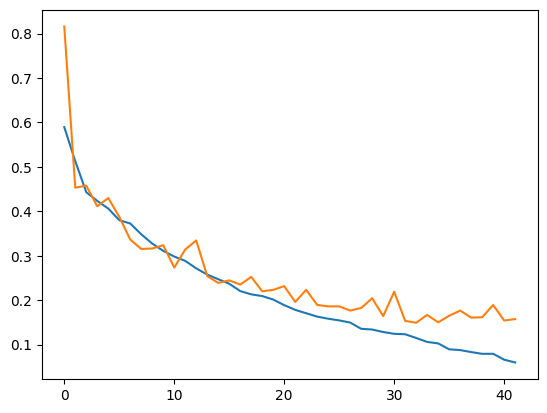

In [37]:
lossOverTimneToEnd = lossesOverTime[1:]
print()
plt.plot(lossOverTimneToEnd)

In [20]:
model.eval()
color, mask = train_dataset.__getitem__(37)
plt.imshow(model(color))

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor